In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from math import e
import seaborn as sns
from collections import Counter
sns.set_style("whitegrid")

ModuleNotFoundError: No module named 'seaborn'

In [2]:
def redistribute_force(F, L, alpha, F_thr, neighborhood='moore'):
    # Create a copy of the forces to store the new values
    F_new = np.copy(F)
    # List of active sites
    active_sites = []

    # Find active sites
    for i in range(L):
        for j in range(L):
            if F[i, j] >= F_thr:
                active_sites.append((i, j))

    # Redistribute forces from active sites
    for site in active_sites:
        i, j = site
        force_to_redistribute = F[i, j]

        # Define the neighborhood for force redistribution
        if neighborhood == 'moore':
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                         (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        else:  # von Neumann neighborhood
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

        # count no of neighbors 
        neighbors_count = 0    
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                neighbors_count += 1
        
        # Redistribute the force to the neighbors
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                F_new[ni, nj] += (alpha * force_to_redistribute)/neighbors_count

        # Set the force of the active site to zero
        F_new[i, j] = 1

    return F_new, active_sites

def simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore'):
    # Initialize the grid with random forces
    F = np.random.rand(L, L)
    initial_state = np.copy(F)

    active = True
    active_sites_count = 0
    active_sites_array = []
    while active:
        # Redistribute forces and get list of active sites
        F, active_sites = redistribute_force(F, L, alpha, F_thr, neighborhood)
        # If there are no active sites, break the loop
        active = len(active_sites) > 0
        active_sites_count += len(active_sites)

        if not active and n_additions > 0:
            # Locate site with the block closest to slip
            i, j = np.unravel_index(np.argmin(F_thr - F), F.shape)
            # Add the difference to all sites
            F += (F_thr - F[i, j])
            n_additions -= 1
            active_sites_array.append(active_sites_count)
            active_sites_count = 0
            active = True

    return initial_state, F, active_sites_array

def visualize_states(initial_state, final_state, title='Cellular Automata States'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Initial state visualization
    ax1 = axes[0]
    im1 = ax1.imshow(initial_state, cmap='viridis', interpolation='nearest')
    ax1.set_title('Initial State')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    # Final state visualization
    ax2 = axes[1]
    im2 = ax2.imshow(final_state, cmap='viridis', interpolation='nearest')
    ax2.set_title('Final State')
    fig.colorbar(im2, ax=ax2, orientation='vertical')

    # Overall title and show
    plt.suptitle(title)
    plt.show()


In [ ]:
def add_noise_to_values(values, noise_percentage):
    """
    Add random noise to an array of values.
    The noise is both positive and negative, given as a percentage of the actual values.

    :param values: Numpy array of original values.
    :param noise_percentage: The percentage of the original value by which to vary.
    :return: Numpy array with noise added.
    """
    # Calculate noise as a percentage of each value
    noise = np.random.uniform(-noise_percentage, noise_percentage, values.shape) / 100.0
    noisy_values = values + (values * noise)
    return noisy_values

def generate_normal_distribution(size, mean, std, lower_limit):
    """
    Generate an array of values with a given size, mean, and standard deviation,
    with the constraint that all values are above a specified lower limit.

    :param size: Size of the array to generate.
    :param mean: Mean value of the normal distribution.
    :param std: Standard deviation of the normal distribution.
    :param lower_limit: The lower limit for the values.
    :return: Numpy array of generated values.
    """
    values = np.random.normal(mean, std, size)

    # Ensure all values are above the lower limit
    values = np.maximum(values, lower_limit)

    return values

def redistribute_force(F, L, alpha, F_thr, F_res, neighborhood='moore'):
    F_new = np.copy(F)
    active_sites = []

    for i in range(L):
        for j in range(L):
            if F[i, j] >= F_thr[i, j]:  # Use individual cell thresholds
                active_sites.append((i, j))

    for site in active_sites:
        i, j = site
        force_to_redistribute = F[i, j] - F_res[i, j]

        if neighborhood == 'moore':
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                         (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        else:
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

        neighbors_count = sum(1 for ni, nj in neighbors if 0 <= ni < L and 0 <= nj < L)
        
        for ni, nj in neighbors:
            if 0 <= ni < L and 0 <= nj < L:
                F_new[ni, nj] += (alpha * force_to_redistribute) / neighbors_count

        F_new[i, j] = F_res[i,j]  # Resetting the active site to a residual force

    return F_new, active_sites

def simulate_ca(L, alpha, mean_thr, std_thr, min_thr, mean_res, std_res,min_res, n_additions, neighborhood='moore'):
    F = np.random.rand(L, L)*min_thr
    initial_state = np.copy(F)
    # F_thr = add_noise_to_values(np.full((L, L), mean_thr), noise_thr)
    # F_res = add_noise_to_values(np.full((L, L), mean_res), noise_res)

    F_thr = generate_normal_distribution((L, L), mean_thr, std_thr, min_thr)
    F_res = generate_normal_distribution((L, L), mean_res, std_res, min_res)

    active = True
    active_sites_count = 0
    active_sites_array = []
    while active:
        F, active_sites = redistribute_force(F, L, alpha, F_thr, F_res, neighborhood)
        active = len(active_sites) > 0
        active_sites_count += len(active_sites)

        if not active and n_additions > 0:
            i, j = np.unravel_index(np.argmin(F_thr - F), F.shape)
            F += (F_thr[i, j] - F[i, j])
            n_additions -= 1
            active_sites_array.append(active_sites_count)
            active_sites_count = 0
            active = True

    return initial_state, F, active_sites_array

def visualize_states(initial_state, final_state, title='Cellular Automata States'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1 = axes[0]
    im1 = ax1.imshow(initial_state, cmap='viridis', interpolation='nearest')
    ax1.set_title('Initial State')
    fig.colorbar(im1, ax=ax1, orientation='vertical')
    ax2 = axes[1]
    im2 = ax2.imshow(final_state, cmap='viridis', interpolation='nearest')
    ax2.set_title('Final State')
    fig.colorbar(im2, ax=ax2, orientation='vertical')
    plt.suptitle(title)
    plt.show()

# Parameters
L = 50  # Size of the lattice
alpha = 0.5  # Coupling constant
mean_thr = 9.0  # Mean threshold
std_thr = 1.0  # std dev of threshold
min_thr = 1.0  # Minimum threshold
mean_res = 2.0  # Mean residual force
std_res = 0.5  # std dev of residual force
min_res = 0.5  # Minimum residual force
n_additions = 10000  # Number of additions

# Run the simulation
initial_state, final_state, active_sites_array = simulate_ca(L, alpha, mean_thr, std_thr, min_thr, mean_res, std_res, min_res, n_additions, neighborhood='moore')

# Visualize the initial and final states
visualize_states(initial_state, final_state, title='Cellular Automata States (Moore Neighborhood)')


In [3]:
# Parameters
L = 25  # Size of the lattice
alpha = 0.5  # Coupling constant
F_thr = 4.0  # Threshold force
n_additions = 10000 # Number of additions of force to the system

# Run the simulation for Moore neighborhood
initial_state_moore, final_state_moore, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')

# Visualize the initial and final states for Moore neighborhood
#visualize_states(initial_state_moore, final_state_moore, title='Cellular Automata States (Moore Neighborhood)')

# Run the simulation for Von Neumann neighborhood
initial_state_von, final_state_von, active_sites_von = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='von_neumann')

# Visualize the initial and final states for Von Neumann neighborhood
#visualize_states(initial_state_von, final_state_von, title='Cellular Automata States (Von Neumann Neighborhood)')

In [4]:
n_simulations = 100
active_sites_moore_array = []
for i in range(n_simulations):
    print((i+1)/n_simulations*100,"%", sep=' ', end=' ', flush=True)
    _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
    active_sites_moore_array.append(active_sites_moore)

1.0 % 2.0 % 3.0 % 4.0 % 5.0 % 6.0 % 7.000000000000001 % 8.0 % 9.0 % 10.0 % 11.0 % 12.0 % 13.0 % 14.000000000000002 % 15.0 % 16.0 % 17.0 % 18.0 % 19.0 % 20.0 % 21.0 % 22.0 % 23.0 % 24.0 % 25.0 % 26.0 % 27.0 % 28.000000000000004 % 28.999999999999996 % 30.0 % 31.0 % 32.0 % 33.0 % 34.0 % 35.0 % 36.0 % 37.0 % 38.0 % 39.0 % 40.0 % 41.0 % 42.0 % 43.0 % 44.0 % 45.0 % 46.0 % 47.0 % 48.0 % 49.0 % 50.0 % 51.0 % 52.0 % 53.0 % 54.0 % 55.00000000000001 % 56.00000000000001 % 

KeyboardInterrupt: 

1000000


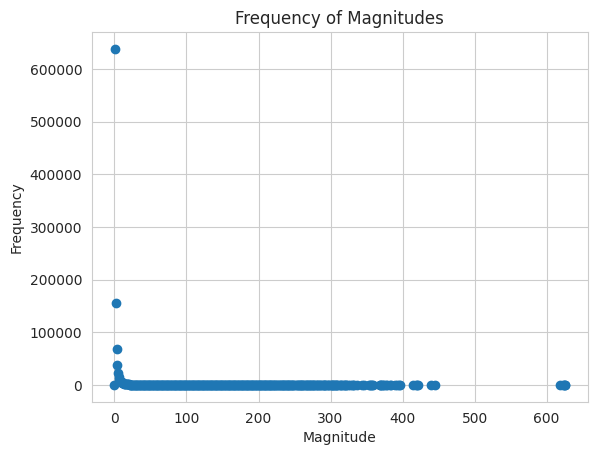

In [27]:
flattened_list = [item for sublist in active_sites_moore_array for item in sublist]
print(len(flattened_list))
occurrences_counter = Counter(flattened_list)
sorted_data = dict(sorted(occurrences_counter.items()))

magnitudes = list(occurrences_counter.keys())
frequencies = list(occurrences_counter.values())

plt.scatter(magnitudes, frequencies)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Frequency of Magnitudes')
plt.show()

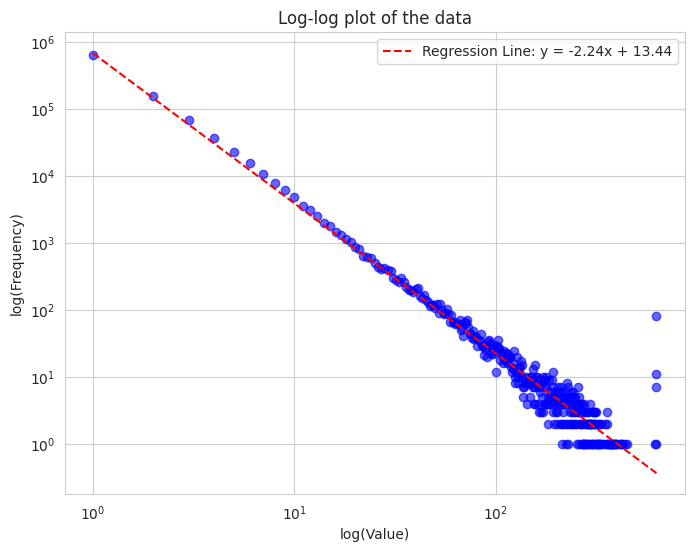

Slope: -2.2430326783710735
Intercept: 13.437548355449083
R-squared: 0.9438746971762542
P-value: 7.499969928751769e-218


In [28]:
values = np.array(list(occurrences_counter.keys()))
frequencies = np.array(list(occurrences_counter.values()))

non_zero_indices = values > 0
values = values[non_zero_indices]
frequencies = frequencies[non_zero_indices]

slope, intercept, r_value, p_value, std_err = linregress(np.log(values), np.log(frequencies))

plt.figure(figsize=(8, 6))
plt.scatter(values, frequencies, color='blue', alpha=0.6)
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the data')

x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(e ** x,e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
plt.legend()
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

2.0 % 4.0 % 6.0 % 8.0 % 10.0 % 12.0 % 14.000000000000002 % 16.0 % 18.0 % 20.0 % 22.0 % 24.0 % 26.0 % 28.000000000000004 % 30.0 % 32.0 % 34.0 % 36.0 % 38.0 % 40.0 % 42.0 % 44.0 % 46.0 % 48.0 % 50.0 % 52.0 % 54.0 % 56.00000000000001 % 57.99999999999999 % 60.0 % 62.0 % 64.0 % 66.0 % 68.0 % 70.0 % 72.0 % 74.0 % 76.0 % 78.0 % 80.0 % 82.0 % 84.0 % 86.0 % 88.0 % 90.0 % 92.0 % 94.0 % 96.0 % 98.0 % 100.0 % 

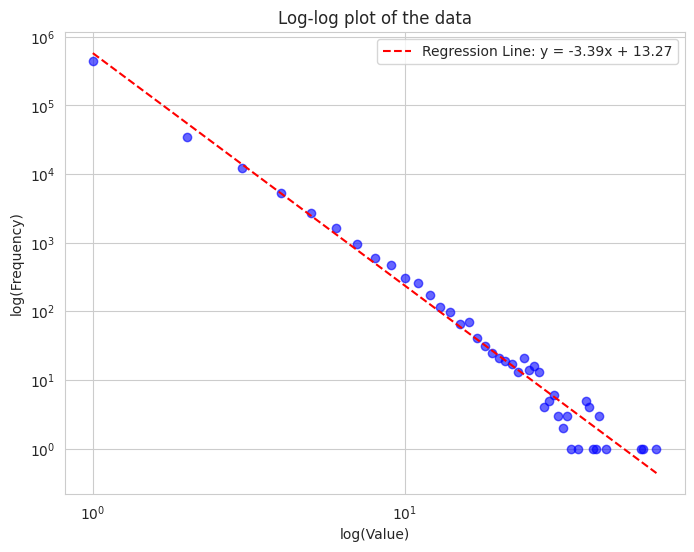

Slope: -3.386572008318
Intercept: 13.269260897467605
R-squared: 0.9765811752996414
P-value: 7.1368574219055e-36


In [6]:
# Parameters
L = 25  # Size of the lattice
alpha = 0.2  # Coupling constant
F_thr = 4.0  # Threshold force
n_additions = 10000 # Number of additions of force to the system
n_simulations = 50
active_sites_moore_array = []

# Num of sims
for i in range(n_simulations):
    print((i+1)/n_simulations*100,"%", sep=' ', end=' ', flush=True)
    _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
    active_sites_moore_array.append(active_sites_moore)
    
# Process data
flattened_list = [item for sublist in active_sites_moore_array for item in sublist]
occurrences_counter = Counter(flattened_list)
magnitudes = list(occurrences_counter.keys())
frequencies = list(occurrences_counter.values())
values = np.array(list(occurrences_counter.keys()))
frequencies = np.array(list(occurrences_counter.values()))

# Filter
non_zero_indices = values > 0
values = values[non_zero_indices]
frequencies = frequencies[non_zero_indices]

# Lineair regression
slope, intercept, r_value, p_value, std_err = linregress(np.log(values), np.log(frequencies))
x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(values, frequencies, color='blue', alpha=0.6)
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the data')
plt.plot(e ** x,e ** y, color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
plt.legend()
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

Running simulation for alpha=0.1, L=25...
100.0 % Running simulation for alpha=0.1, L=50...
100.0 % Running simulation for alpha=0.1, L=75...
100.0 % Running simulation for alpha=0.25, L=25...
100.0 % Running simulation for alpha=0.25, L=50...
100.0 % Running simulation for alpha=0.25, L=75...
100.0 % Running simulation for alpha=0.5, L=25...
100.0 % Running simulation for alpha=0.5, L=50...
100.0 % Running simulation for alpha=0.5, L=75...
100.0 % 

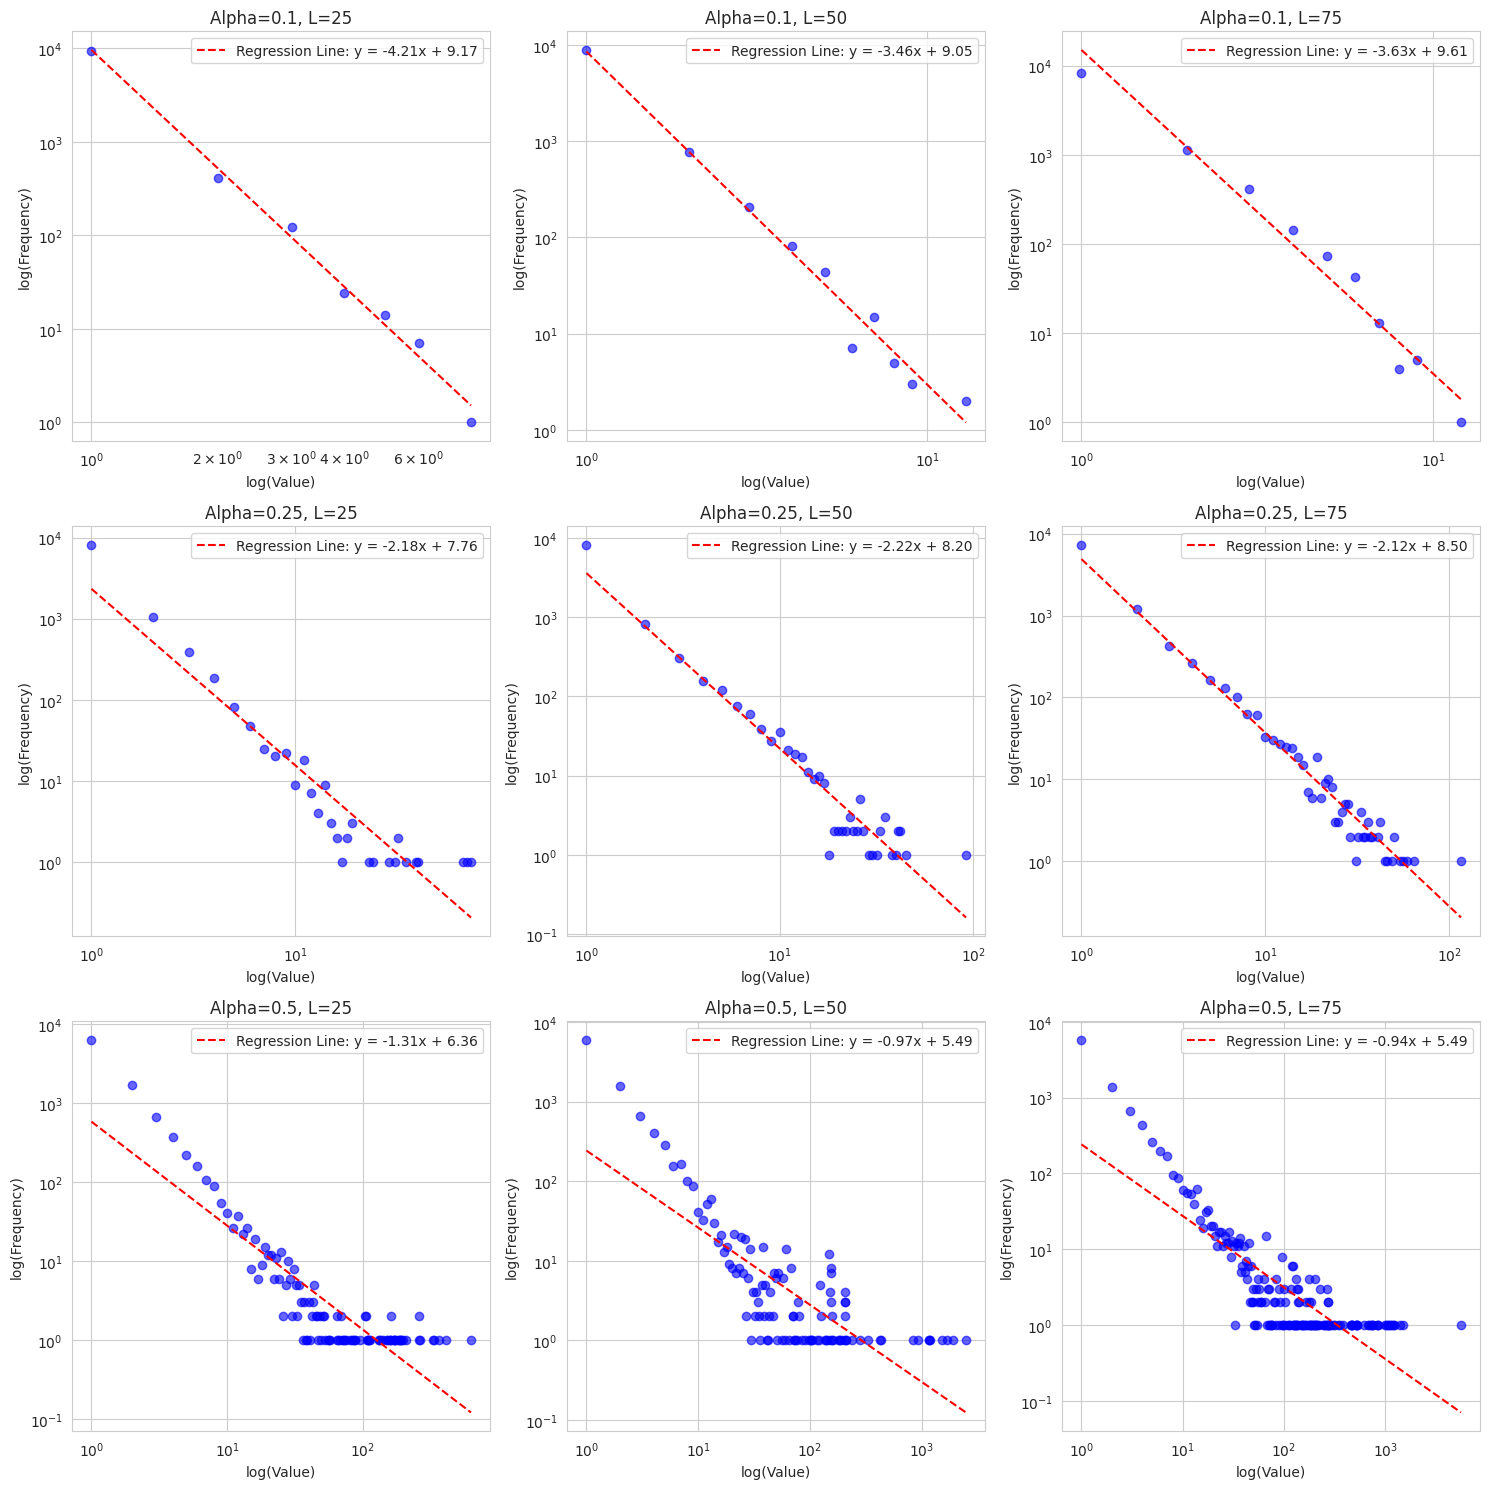

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from collections import Counter

# Define parameters to vary
alphas = [0.1, 0.25, 0.5]  # Varying values for alpha
L_values = [25, 50, 75]     # Varying values for L

# Number of additions of force to the system
n_additions = 10000

# Number of simulations
n_simulations = 1
F_thr = 4.0 

# Create a 3x3 plot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over different values of alpha and L
for i, alpha in enumerate(alphas):
    for j, L in enumerate(L_values):
        print(f"Running simulation for alpha={alpha}, L={L}...")
        
        # Arrays to store results of each simulation
        active_sites_moore_array = []
        
        # Perform simulations
        for k in range(n_simulations):  # Change the loop variable to k
            print((k+1)/n_simulations*100,"%", sep=' ', end=' ', flush=True)
            _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
            active_sites_moore_array.append(active_sites_moore)
        
        # Compute the average of the results
        average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
        
        # Process data
        occurrences_counter = Counter(average_active_sites_moore)
        magnitudes = list(occurrences_counter.keys())
        frequencies = list(occurrences_counter.values())
        values = np.array(list(occurrences_counter.keys()))
        frequencies = np.array(list(occurrences_counter.values()))

        # Filter
        non_zero_indices = values > 0
        values = values[non_zero_indices]
        frequencies = frequencies[non_zero_indices]

        # Linear regression
        slope, intercept, r_value, p_value, std_err = linregress(np.log(values), np.log(frequencies))
        x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
        y = slope * x + intercept

        # Plot on the corresponding subplot
        ax = axes[i, j]
        ax.scatter(values, frequencies, color='blue', alpha=0.6)
        ax.set_xlabel('log(Value)')
        ax.set_ylabel('log(Frequency)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'Alpha={alpha}, L={L}')
        ax.plot(np.exp(x), np.exp(y), color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
        ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Running simulation for alpha=0.1, L=15...
100% 

Running simulation for alpha=0.1, L=25...
100% 

Running simulation for alpha=0.1, L=50...
100% 

Running simulation for alpha=0.2, L=15...
100% 

Running simulation for alpha=0.2, L=25...
100% 

Running simulation for alpha=0.2, L=50...
100% 

Running simulation for alpha=0.3, L=15...
100% 

Running simulation for alpha=0.3, L=25...
100% 

Running simulation for alpha=0.3, L=50...
100% 



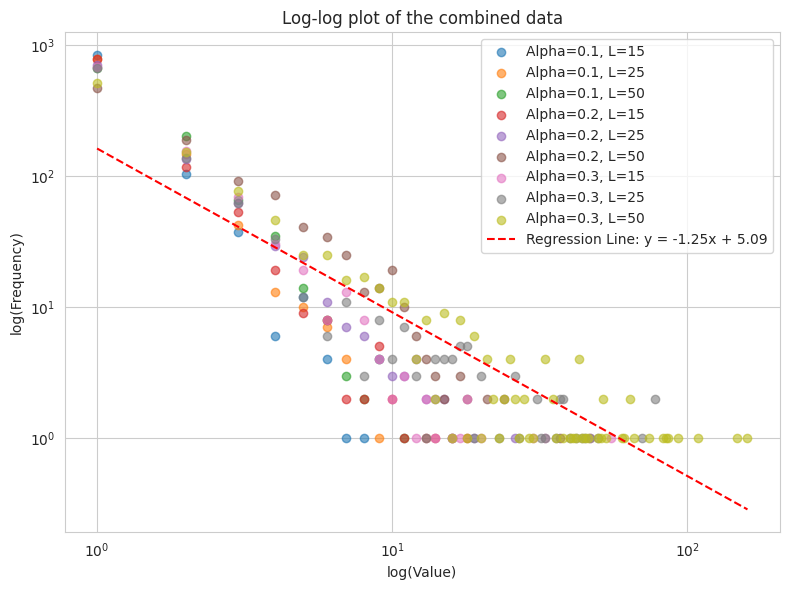

In [21]:
# Define parameters to vary
alphas = [0.1, 0.2, 0.3]  # Varying values for alpha
L_values = [15,25,50]     # Varying values for L

# Number of additions of force to the system
n_additions = 1000

# Number of simulations
n_simulations = 1
F_thr = 4.0 

# Create a single plot
plt.figure(figsize=(8, 6))

# Iterate over different values of alpha and L
for alpha in alphas:
    for L in L_values:
        print(f"Running simulation for alpha={alpha}, L={L}...")
        
        # Arrays to store results of each simulation
        active_sites_moore_array = []
        
        # Perform simulations
        for i in range(n_simulations):
            print(round((i+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
            _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
            active_sites_moore_array.append(active_sites_moore)
        
        # Compute the average of the results
        average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
        
        # Process data
        occurrences_counter = Counter(average_active_sites_moore)
        magnitudes = list(occurrences_counter.keys())
        frequencies = list(occurrences_counter.values())
        values = np.array(list(occurrences_counter.keys()))
        frequencies = np.array(list(occurrences_counter.values()))

        # Filter
        non_zero_indices = values > 0
        values = values[non_zero_indices]
        frequencies = frequencies[non_zero_indices]
        
        # Perform linear regression
        slope, intercept, _, _, _ = linregress(np.log(values), np.log(frequencies))

        # Plot the data points with a unique color for each combination
        plt.scatter(values, frequencies, label=f'Alpha={alpha}, L={L}', alpha=0.6)
        print("\n")

# Add linear regression line
x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(np.exp(x), np.exp(y), color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

# Set plot labels and title
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-log plot of the combined data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Running simulation for alpha=0.1, L=15, Threshold=2.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.1, L=25, Threshold=2.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.1, L=50, Threshold=2.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.1, L=15, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.1, L=25, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.1, L=50, Threshold=4.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.1, L=15, Threshold=6.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.1, L=25, Threshold=6.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.1, L=50, Threshold=6.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation for alpha=0.2, L=15, Threshold=2.0...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Running simulation f

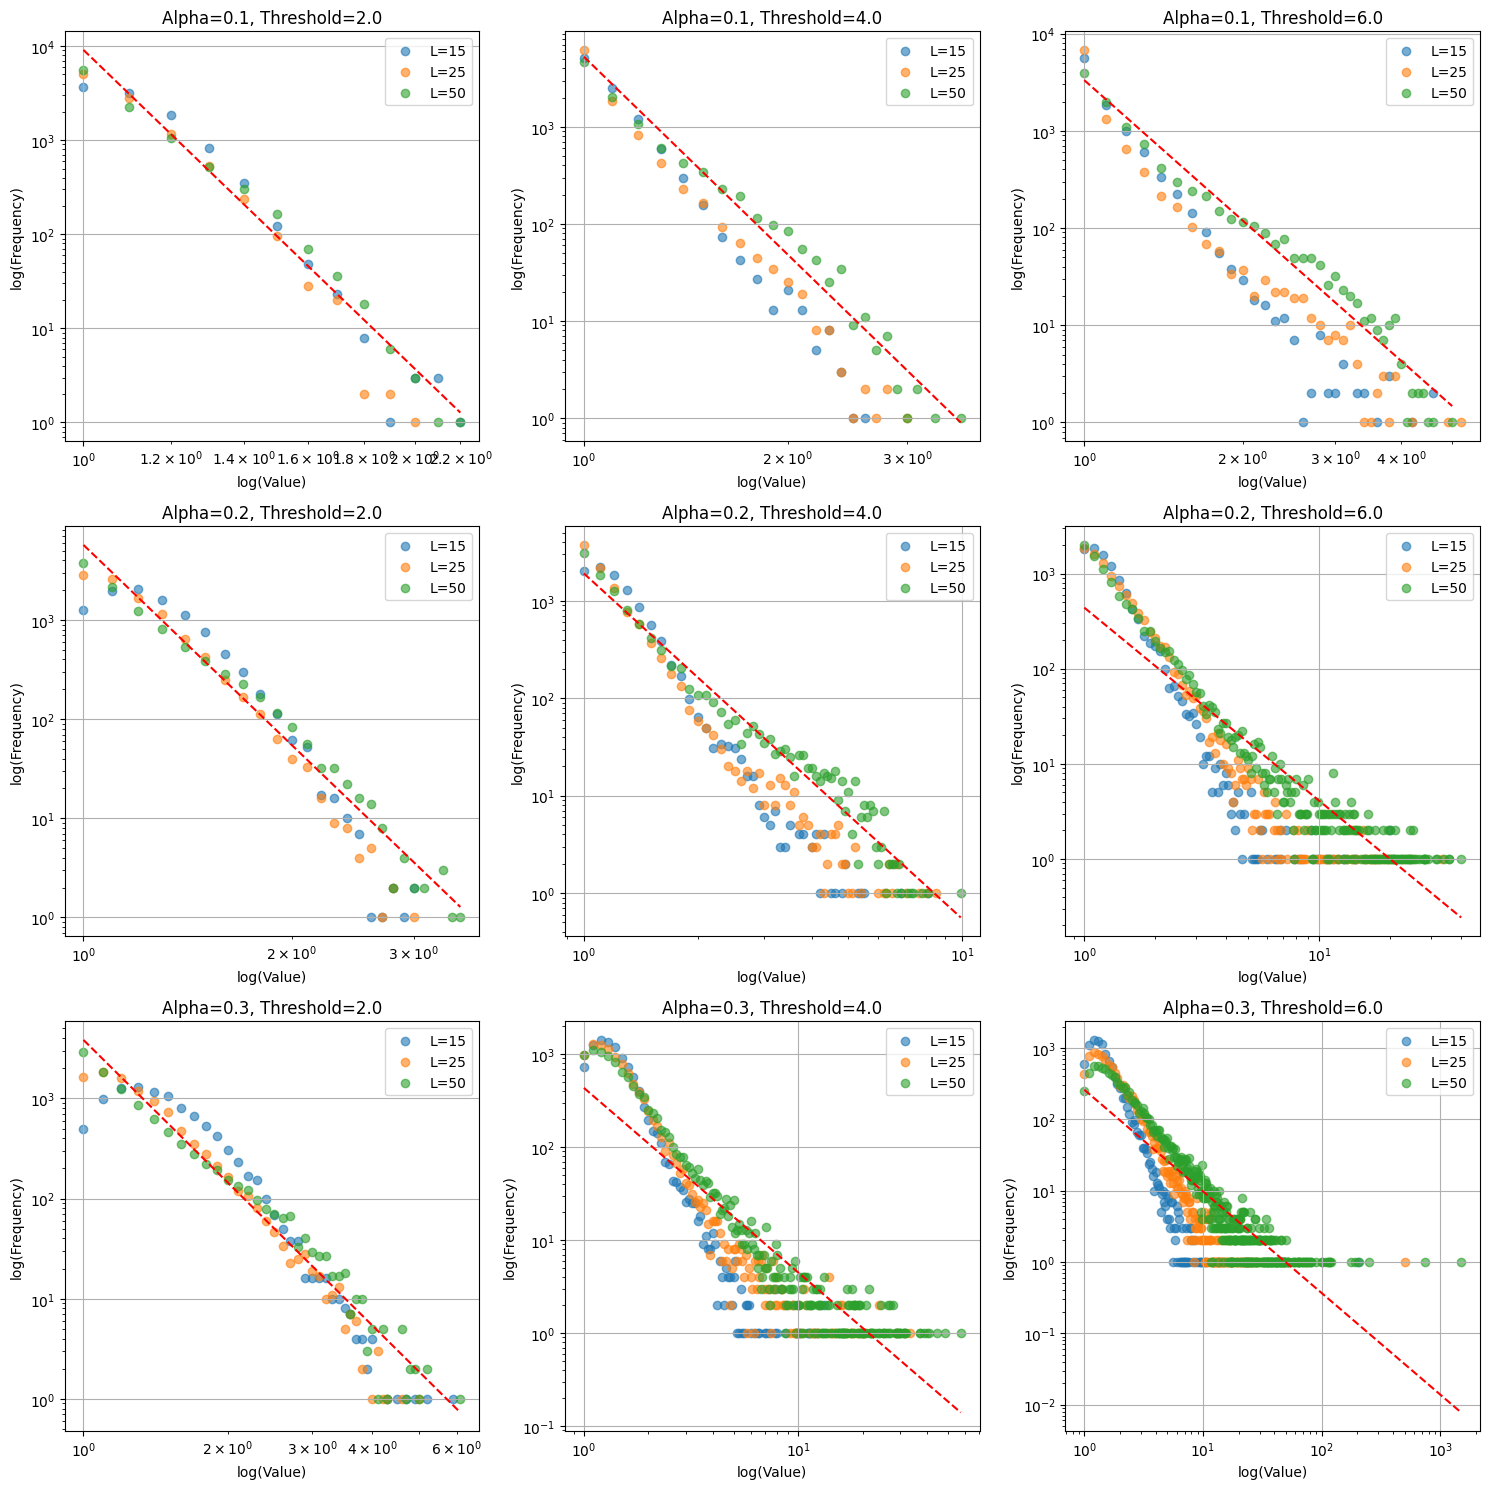

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from collections import Counter

# Define parameters to vary
alphas = [0.1, 0.2, 0.3]  # Varying values for alpha
L_values = [15, 25, 50]     # Varying values for L
thresholds = [2.0, 4.0, 6.0] # Varying values for threshold

# Number of additions of force to the system
n_additions = 10000

# Number of simulations
n_simulations = 10

# Create a 3x3 plot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over different values of alpha, L, and threshold
for i, alpha in enumerate(alphas):
    for j, F_thr in enumerate(thresholds):
        for k, L in enumerate(L_values):
            print(f"Running simulation for alpha={alpha}, L={L}, Threshold={F_thr}...")
            
            # Arrays to store results of each simulation
            active_sites_moore_array = []
            
            # Perform simulations
            for z in range(n_simulations):
                print(round((z+1)/n_simulations*100),"%", sep='', end=' ', flush=True)
                _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
                active_sites_moore_array.append(active_sites_moore)
            
            # Compute the average of the results
            average_active_sites_moore = np.mean(active_sites_moore_array, axis=0)
            
            # Process data
            occurrences_counter = Counter(average_active_sites_moore)
            magnitudes = list(occurrences_counter.keys())
            frequencies = list(occurrences_counter.values())
            values = np.array(list(occurrences_counter.keys()))
            frequencies = np.array(list(occurrences_counter.values()))

            # Filter
            non_zero_indices = values > 0
            values = values[non_zero_indices]
            frequencies = frequencies[non_zero_indices]
            
            

            # Plot on the corresponding subplot
            ax = axes[i, j]
            ax.scatter(values, frequencies, label=f'L={L}', alpha=0.6)
            ax.set_xlabel('log(Value)')
            ax.set_ylabel('log(Frequency)')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_title(f'Alpha={alpha}, Threshold={F_thr}')
            ax.legend()
            ax.grid(True)

        # Perform linear regression
        slope, intercept, _, _, _ = linregress(np.log(values), np.log(frequencies))
        x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
        y = slope * x + intercept
        ax.plot(np.exp(x), np.exp(y), color = 'red', linestyle = '--', label = f'Regression line: y = {slope:.2f}x + {intercept:.2f}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
